<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# Deep Convolutional Generative Adversarial Networks (DCGANs)


Estimated time needed: **30** minutes

You work for an online anime video game company; the company would like to create a unique anime avatar for a game for each player. As there are millions of players, you must use a DCGANs to create each character. 


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module6/face_cartton.png" width="700" alt="Skills Network Logo">


## Table of Contents

<ol>
    <li><a href="https://#Objectives">Objectives</a></li>
    <li>
        <a href="https://#Setup">Setup</a>
        <ol>
            <li><a href="#Installing-Required-Libraries">Installing Required Libraries</a></li>
            <li><a href="#Importing-Required-Libraries">Importing Required Libraries</a></li>
            <li><a href="#Defining Helper Functions">Defining Helper Functions</a></li>
        </ol>       
    </li>
    <li><a href="#Introduction">Introduction</a></li>
    <li><a href="#Loading the Dataset">Loading the Dataset</a></li>
    <li><a href="#Creating Data Generator">Creating Data Generator</a></li>
    <li><a href="#Generator and Discriminator">Generator and Discriminator</a>
        <ol>
            <li><a href="#Building the Generator">Building the Generator</a></li>
            <li><a href="#Building the Discriminator">Building the Discriminator</a></li>
        </ol>  
    </li>   
    <li><a href="#Defining Loss Functions">Defining Loss Functions</a></li>
    <li><a href="#Defining Optimizers">Defining Optimizers </a></li>
    <li><a href="#Create Train Step Function">Create Train Step Function</a></li>
    <li><a href="#Training the Model">Training the Model</a>
         <ol>
            <li><a href="#Loading Pre-trained model (150 epochs)">Loading Pre-trained model (150 epochs)</a></li>
        </ol>  
    </li>     
    <li><a href="#Explore Latent Variables">Explore Latent Variables</a>
        <ol>
            <li><a href="#Exercise 1">Exercise 1</a></li>
            <li><a href="#Exercise 2">Exercise 2</a></li>
            <li><a href="#Exercise 3">Exercise 3</a></li>
        </ol>       
    </li>
</ol>



## Objectives

After completing this lab you will be able to:

*   Apply DCGANs to a dataset 
*   Understand how to train DCGANs 
*   Generate an image using a DCGAN
*   Understand how changing the input of the latent space of DCGANs changes the generated image 


## Setup


For this lab, we will be using the following libraries:

*   [`numpy`](https://numpy.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for mathematical operations.
*   [`Pillow`](https://pillow.readthedocs.io/en/stable/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for image processing functions.
*   [`tensorflow`](https://www.tensorflow.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for machine learning and neural network related functions.
*   [`matplotlib`](https://matplotlib.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for additional plotting tools.


### Installing Required Libraries

The following required libraries are pre-installed in the Skills Network Labs environment. However, if you run this notebook command in a different Jupyter environment (like Watson Studio or Anaconda), you will need to install these libraries by removing the `#` sign before `!mamba` in the code cell below.


In [ ]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
#!mamba install -qy numpy==1.22.3 matplotlib==3.5.1 tensorflow==2.9.0 skillsnetwork==0.20.6

# Note: If your environment doesn't support "!mamba install", use "!pip install --user"

# RESTART YOUR KERNEL AFTERWARD AS WELL

Run the following upgrade and then **RESTART YOUR KERNEL**. Make sure the version of tensorflow imported below is **no less than 2.9.0**.


In [ ]:
 %%capture
!pip3 install --upgrade tensorflow

### Importing Required Libraries

*We recommend you import all required libraries in one place (here):*


In [1]:
import warnings
warnings.simplefilter('ignore')

import keras

import numpy as np
import tensorflow as tf
print(f"tensorflow version: {tf.__version__}")

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2DTranspose,BatchNormalization,ReLU,Conv2D,LeakyReLU


from IPython import display
import skillsnetwork
print(f"skillsnetwork version: {skillsnetwork.__version__}")

import matplotlib.pyplot as plt

%matplotlib inline


import os
from os import listdir
from pathlib import Path
import imghdr

import time
from tqdm.auto import tqdm


tensorflow version: 2.18.0-dev20240815
skillsnetwork version: 0.21.9


### Defining Helper Functions

This function will plot five images from an array


In [2]:
def plot_array(X,title=""):
    
    plt.rcParams['figure.figsize'] = (20,20) 

    for i,x in enumerate(X[0:5]):
        x=x.numpy()
        max_=x.max()
        min_=x.min()
        xnew=np.uint(255*(x-min_)/(max_-min_))
        plt.subplot(1,5,i+1)
        plt.imshow(xnew)
        plt.axis("off")

    plt.show()

## Introduction


In the previous lab, you learned about the working mechanics of Generative Adversarial Networks (GANs) and their various applications, such as Image Generation. However, GANs have also been known to be unstable to train, and often, the generated images suffer from being noisy and incomprehensible.

Applying Convolutional Neural Networks to GANS has led to improved results. They are called Deep Convolutional Generative Adversarial Networks (DCGANs). In this lab, we will build and train DCGANs using several approaches introduced in the original <a href="https://arxiv.org/pdf/1511.06434.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01">DCGANs paper</a>. 


The proposed approaches are summarized here:


- Replace any pooling layers with **strided convolutions (discriminator)** and **fractional-strided
convolutions (generator)**.
- Use **batchnorm** in both the generator and the discriminator.
- **Remove fully connected hidden layers** for deeper architectures.
- Use **ReLU** activation in generator for all layers except for the output, which uses **Tanh**.
- Use **LeakyReLU** activation in the discriminator for all layers except for the output, which uses **Sigmoid**.
- Use **Adam optimizer**.  

These approaches will result in more stable training of deeper generative models.


## Loading the Dataset

We will mainly work with the Anime Face dataset from [Kaggle](https://www.kaggle.com/datasets/splcher/animefacedataset?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01). The original dataset has 63,632 "high-quality" anime faces, but to make the models train faster in this lab, we randomly sampled 20,000 images and prepared a dataset called `cartoon_20000`. 

Let's download the smaller dataset using the Skills Network library's `prepare` function:


The Anime Face or the Cartoon images are stored in the `cartoon_2000` folder in your current working directory. As a preprocessing step, we have removed any files that are not proper image formats (based on the file extensions) and any duplicate images.


## Creating Data Generator


First, we declare some properties of our images, including image height, image width, and batch size.


In [3]:
img_height, img_width, batch_size=64,64,128

Next, we create a Keras <code>image_dataset_from_directory</code> object with a specified image directory and the parameters are defined as above. This process may take some time:


In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(directory='cartoon_20000', # change directory to 'cartoon_data' if you use the full dataset
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size,
                                                       label_mode=None)


Found 20000 files.


The `train_ds` we defined is a `tf.data.Dataset` that yields batches of images with `image_size = (64, 64)` from the directory specified or subdirectories (if any).


**(OPTIONAL)** If you are running this notebook locally and you have multiple cores, then we can use the runtime to tune the value dynamically at runtime as follows:


In [ ]:
#AUTOTUNE = tf.data.experimental.AUTOTUNE

#train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

We apply the Lambda function on `train_ds` to normalize the pixel values of all the input images from $[0, 255]$ to $[-1, 1]$:


In [7]:
normalization_layer = layers.Rescaling(scale= 1./127.5, offset=-1)
normalized_ds = train_ds.map(lambda x: normalization_layer(x))

Let's take one batch of images for displaying:


In [8]:
images=train_ds.take(1)

Convert the batch dimension to the indexes in a list:


In [9]:
X=[x for x in images]

We can then plot the first five images in the batch using the function   ```plot_array```:


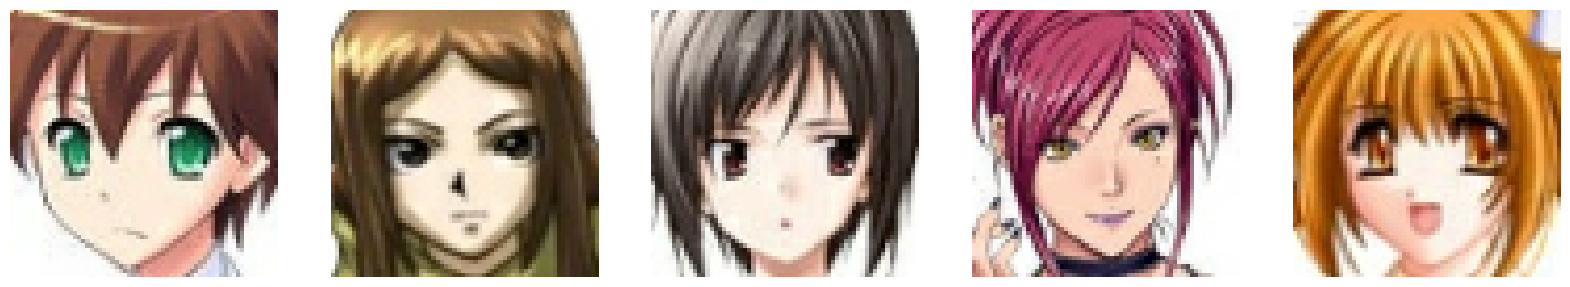

In [10]:
plot_array(X[0])

##  Generator and Discriminator


### Building the Generator


The Generator is comprised of several layers of transposed convolution, the opposite of convolution operations.

- Each Conv2DTranspose layer (except the final layer) is followed by a Batch Normalization layer and a **Relu activation**; for more implementation details, check out <a href="https://arxiv.org/pdf/1511.06434.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01">[1]</a>. 
- The final transpose convolution layer has three output channels since the output needs to be a color image. We use the **Tanh activation** in the final layer. 

See the illustration of the architecture from <a href="https://arxiv.org/pdf/1511.06434.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01">[1]</a> below.

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module6/generator.png" alt="generator image" width="80%"></center>

We build the Generator network by using the parameter values from <a href="https://learnopencv.com/deep-convolutional-gan-in-pytorch-and-tensorflow/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01" >[2]<a>.


In [11]:
def make_generator():
    
    model=Sequential()
    
    # input is latent vector of 100 dimensions
    model.add(Input(shape=(1, 1, 100), name='input_layer'))
    
    # Block 1 dimensionality of the output space  64 * 8
    model.add(Conv2DTranspose(64 * 8, kernel_size=4, strides= 4, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_1'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1'))
    model.add(ReLU(name='relu_1'))

    # Block 2: input is 4 x 4 x (64 * 8)
    model.add(Conv2DTranspose(64 * 4, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_2'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2'))
    model.add(ReLU(name='relu_2'))

    # Block 3: input is 8 x 8 x (64 * 4)
    model.add(Conv2DTranspose(64 * 2, kernel_size=4,strides=  2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_3'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_3'))
    model.add(ReLU(name='relu_3'))

                       
    # Block 4: input is 16 x 16 x (64 * 2)
    model.add(Conv2DTranspose(64 * 1, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_4'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_4'))
    model.add(ReLU(name='relu_4'))

    model.add(Conv2DTranspose(3, 4, 2,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, 
                              activation='tanh', name='conv_transpose_5'))

    return model

By printing the summary of the Generator architecture, we can see that the transposed convolutions **upsample** a 100-dim input vector to a high-dimensional image of size 64 x 64 x 3.


In [12]:
gen = make_generator()
gen.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_transpose_1                │ (None, 4, 4, 512)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 4, 4, 512)      │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_1 (ReLU)                   │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_transpose_2                │ (None, 8, 8, 256)      │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 8, 8, 256)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_2 (ReLU)                   │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_transpose_3                │ (None, 16, 16, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 16, 16, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_3 (ReLU)                   │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_transpose_4                │ (None, 32, 32, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_4 (BatchNormalization)       │ (None, 32, 32, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_4 (ReLU)                   │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_transpose_5                │ (None, 64, 64, 3)      │         3,072 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,578,624 (13.65 MB)

 Trainable params: 3,576,704 (13.64 MB)

 Non-trainable params: 1,920 (7.50 KB)

### Building the Discriminator


The Discriminator has five convolution layers. 

- All but the first and final Conv2D layers have Batch Normalization, since directly applying batchnorm to all layers could result in sample oscillation and model instability; 
- The first four Conv2D layers use the **Leaky-Relu activation** with a slope of 0.2. 
- Lastly, instead of a fully connected layer, the  output layer has a convolution layer with a **Sigmoid activation** function.


In [13]:
def make_discriminator():
    
    model=Sequential()
    
    # Block 1: input is 64 x 64 x (3)
    model.add(Input(shape=(64, 64, 3), name='input_layer'))
    model.add(Conv2D(64, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_1'))
    model.add(LeakyReLU(0.2, name='leaky_relu_1'))

    # Block 2: input is 32 x 32 x (64)
    model.add(Conv2D(64 * 2, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_2'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1'))
    model.add(LeakyReLU(0.2, name='leaky_relu_2'))

    # Block 3
    model.add(Conv2D(64 * 4, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_3'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2'))
    model.add(LeakyReLU(0.2, name='leaky_relu_3'))


    #Block 4
    model.add(Conv2D(64 * 8, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_4'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_3'))
    model.add(LeakyReLU(0.2, name='leaky_relu_4'))


    #Block 5
    model.add(Conv2D(1, 4, 2,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False,  
                     activation='sigmoid', name='conv_5'))

    return model 

By printing the summary of the Discriminator architecture, we can see that the strided convolutions **downsample** an input image of size 64 x 64 x 3.


In [14]:
disc = make_discriminator()
disc.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 32, 32, 64)     │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_1 (LeakyReLU)        │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 16, 16, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 16, 16, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_2 (LeakyReLU)        │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 8, 8, 256)      │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 8, 8, 256)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_3 (LeakyReLU)        │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 4, 4, 512)      │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 4, 4, 512)      │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_4 (LeakyReLU)        │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 2, 2, 1)        │         8,192 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,767,360 (10.56 MB)

 Trainable params: 2,765,568 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

## Defining Loss Functions

As we discussed in the previous lab, the min-max optimization problem can be formulated by minimizing the cross entropy loss for the Generator and Discriminator.  

The `cross_entropy` object is the Binary Cross Entropy loss that will be used to model the objectives of the two networks.


In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [16]:
def generator_loss(Xhat):
    return cross_entropy(tf.ones_like(Xhat), Xhat)

In [17]:
def discriminator_loss(X, Xhat):
    real_loss = cross_entropy(tf.ones_like(X), X)
    fake_loss = cross_entropy(tf.zeros_like(Xhat), Xhat)
    total_loss = 0.5*(real_loss + fake_loss)
    return total_loss

## Defining Optimizers 
 
We create two Adam optimizers for the discriminator and the generator, respectively. We pass the following arguments to the optimizers:

- learning rate of 0.0002.
- beta coefficients $\beta_1 = 0.5$ and $\beta_2 = 0.999$, which are responsible for computing the running averages of the gradients during backpropagation.


In [19]:
learning_rate = 0.0002

generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

## Create Train Step Function

As this lab is more computationally intensive than the last lab, we convert the training step into a function and then use the  @tf.function decorator, which allows the function to be "compiled" into a **callable TensorFlow graph**. This will speed up the training; for more information, read <a href="https://www.tensorflow.org/guide/function?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01">here </a> 


In [22]:
@tf.function

def train_step(X):
    
    #random samples it was found if you increase the  stander deviation, you get better results 
    z= tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
      # needed to compute the gradients for a list of variables.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #generated sample 
        xhat = generator(z, training=True)
        #the output of the discriminator for real data 
        real_output = discriminator(X, training=True)
        #the output of the discriminator for fake data
        fake_output = discriminator(xhat, training=True)
        
        #loss for each 
        gen_loss= generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
      # Compute the gradients for gen_loss and generator
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Compute the gradients for gen_loss and discriminator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # Ask the optimizer to apply the processed gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

Don't be intimidated by the code above, here is a summary of what a train step accomplishes:

- First, we sample `z`, a batch of noise vectors from a normal distribution ($\mu = 1, \sigma = 1$) and feed it to the Generator.
- The Generator produces generated or "fake" images `xhat`.
- We feed real images `X` and fake images `xhat` to the Discriminator and obtain `real_output` and `fake_output` respectively as the scores.
- We calculate Generator loss `gen_loss` using the `fake_output` from Discriminator since we want the fake images to fool the Discriminator as much as possible.
- We calculate Discriminator loss `disc_loss` using both the `real_output` and `fake_output` since we want the Discriminator to distinguish the two as much as possible.
- We calculate `gradients_of_generator` and  `gradients_of_discriminator` based on the losses obtained.
- Finally, we update the Generator and Discriminator by letting their respective optimizers apply the processed gradients on the trainable model parameters.


We can transform the random noise using the generator. As the generator is not trained yet, the output appears to be noises:


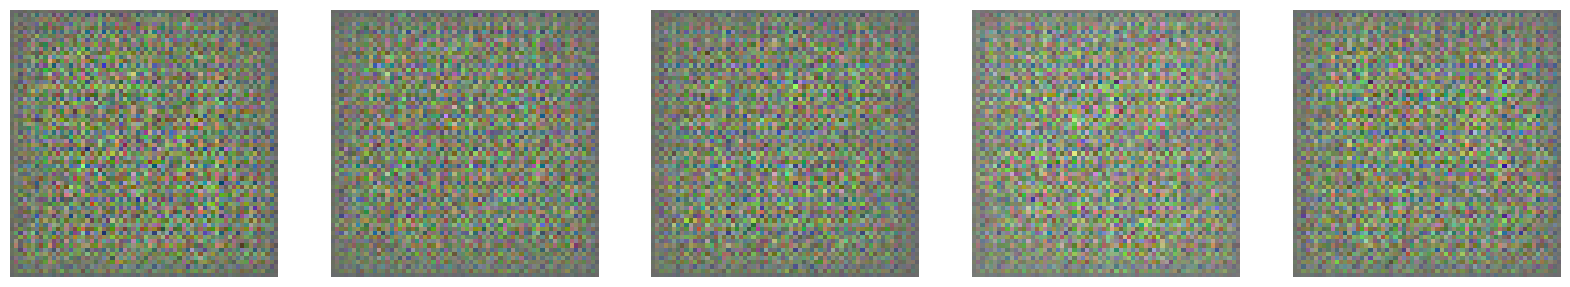

In [23]:
generator= make_generator()
BATCH_SIZE=128

latent_dim=100
noise = tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
Xhat=generator(noise,training=False)
plot_array(Xhat)

## Training the Model


As this method is computationally intensive, we will train the model for one epoch and then use the generator to produce artificial images.


epoch 1:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 1, iteration 1
epoch 1, iteration 2
epoch 1, iteration 3
epoch 1, iteration 4
epoch 1, iteration 5
epoch 1, iteration 6
epoch 1, iteration 7
epoch 1, iteration 8
epoch 1, iteration 9
epoch 1, iteration 10
epoch 1, iteration 11
epoch 1, iteration 12
epoch 1, iteration 13
epoch 1, iteration 14
epoch 1, iteration 15
epoch 1, iteration 16
epoch 1, iteration 17
epoch 1, iteration 18
epoch 1, iteration 19
epoch 1, iteration 20
epoch 1, iteration 21
epoch 1, iteration 22
epoch 1, iteration 23
epoch 1, iteration 24
epoch 1, iteration 25
epoch 1, iteration 26
epoch 1, iteration 27
epoch 1, iteration 28
epoch 1, iteration 29
epoch 1, iteration 30
epoch 1, iteration 31
epoch 1, iteration 32
epoch 1, iteration 33
epoch 1, iteration 34
epoch 1, iteration 35
epoch 1, iteration 36
epoch 1, iteration 37
epoch 1, iteration 38
epoch 1, iteration 39
epoch 1, iteration 40
epoch 1, iteration 41
epoch 1, iteration 42
epoch 1, iteration 43
epoch 1, iteration 44
epoch 1, iteration 45
epoch 1, iteration 

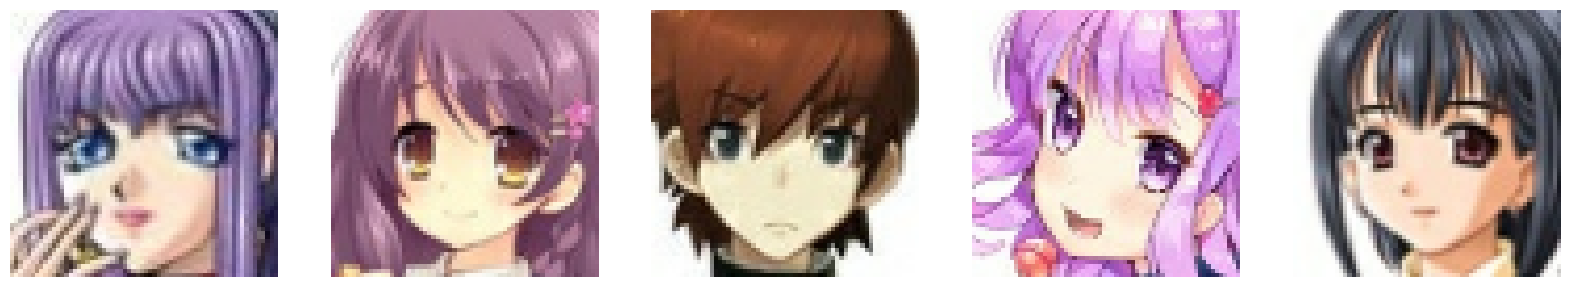

generated images


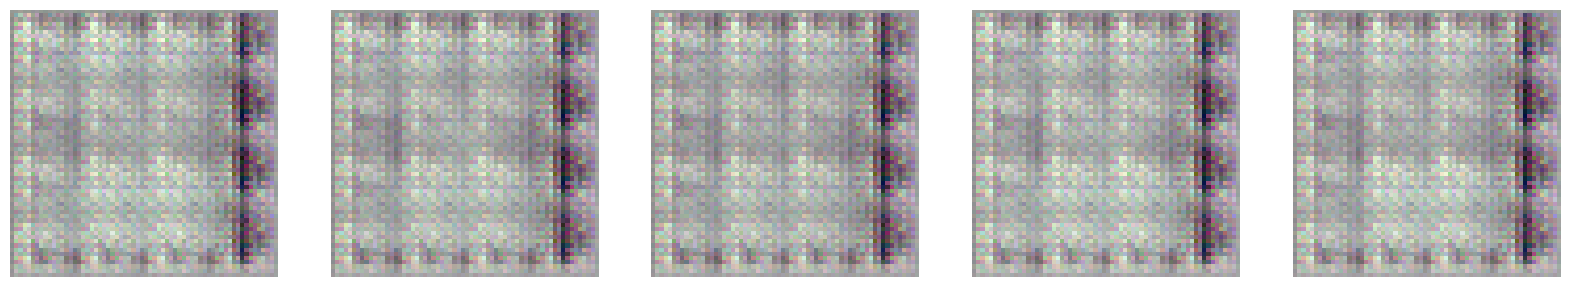

Time for epoch 1 is 138.52297258377075 sec


In [24]:
epochs=1

discriminator=make_discriminator()

generator= make_generator()


for epoch in range(epochs):
    
    #data for the true distribution of your real data samples training ste
    start = time.time()
    i=0
    for X in tqdm(normalized_ds, desc=f"epoch {epoch+1}", total=len(normalized_ds)):
        
        i+=1
        if i%1000:
            print("epoch {}, iteration {}".format(epoch+1, i))
            
        train_step(X)
    

    noise = tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
    Xhat=generator(noise,training=False)
    X=[x for x in normalized_ds]
    print("orignal images")
    plot_array(X[0])
    print("generated images")
    plot_array(Xhat)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

As you can see that, with only one epoch of training and a reduced number of training images, our GAN didn't learn much information, and thus, the generator wasn't able to produce images that make sense to human eyes. There are two quick actions you can take to try to improve the results:

1. Re-train the GAN using the full dataset that has 63,632 images. 
    - To do so, simply go back to the **Loading the Dataset** section, replace the url of the dataset with "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module5/L2/cartoon_data.tgz", change the `directory` argument in `tf.keras.utils.image_dataset_from_directory` to `'cartoon_data'` and re-run all the cells. 
    - Note that using more training data does allows the model to learn better and perform better, but it will result in longer training time! **With 63K training images and batch size of 128, your model will train for ~497 iterations.**


2. Use a pre-trained generator model to generate images.
    - You don't need to experience the training time at all! 
    - Proceed to the next subsection to load a pre-trained model, and you will see that the generator trained with 150 epochs can produce almost realistic anime faces.


### Loading Pre-trained model (150 epochs)


As you saw, training a GAN with only one epoch takes quite a long time. If we want to evaluate the performance of a fully trained and optimized GAN, we would need to increase the number of epochs. Thus, to help you avoid extremely long training time in this lab, we will just download the pre-trained Generator network parameters and then use Kera `load_model` function to obtain a pre-trained Generator, which we will use to generate images directly.


In [ ]:
generator_url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module6/generator.tar.gz"
await skillsnetwork.prepare(generator_url, overwrite=True)

Load the generator:


In [ ]:
from tensorflow.keras.models import load_model


full_generator=load_model("generator")

Let's generate several images using the fully trained Generator and display them:


In [ ]:
latent_dim=100

# input consists of noise vectors
noise = tf.random.normal([200, 1, 1, latent_dim])

# feed the noise vectors to the generator
Xhat=full_generator(noise,training=False)
plot_array(Xhat)

## Explore Latent Variables 
Values of $\mathbf{z}$ that are relatively close together will produce similar images. For example, we can assigns elements of $\mathbf{z}$ close values such as $[1,0.8,..,0.4]$. 


In [ ]:
for c in [1,0.8,0.6,0.4]:
    Xhat=full_generator(c*tf.ones([1, 1, 1, latent_dim]),training=False) # latent_dim = 100 defined previously
    plot_array(Xhat)

### Exercise 1

Plot the generated images by the Generator with elements of $\mathbf{z}$ equal $[-1,-0.8,-0.6,-0.4]$. 


In [ ]:
# Your code here

<details>
    <summary>Click here for Solution</summary>

```python
for c in [1,0.8,0.6,0.4]:
    Xhat=full_generator(-c*tf.ones([1, 1, 1, latent_dim]),training=False)
    plot_array(Xhat)
 ```   

</details>


We can see how changing the latent variable changes the generated image. Here we alter more and more subsequent values of $\mathbf{z}$ from 1 to -1; we see the images change accordingly; this is evident in the anime character's hair color:


In [ ]:
z=np.ones( (1, 1, 1, latent_dim))
for n in range(10):

    z[0, 0, 0, 0:10*n]=-1

    Xhat=full_generator(z,training=False)
    print("elements from 0 to {} is set to -1".format(10*n))
    plot_array(Xhat)

### Exercise 2

Repeat the above procedure but set the latent variable $z[0, 0, 0, 0:20*n] = -0.5*n$ each time `for n in range(5)`


In [ ]:
# Your code here

<details>
    <summary>Click here for Solution</summary>

```python
z=np.ones( (1, 1, 1, latent_dim))
for n in range(5):

    z[0, 0, 0, 0:20*n]=-0.5*n

    Xhat=full_generator(z,training=False)

    plot_array(Xhat)
    

 ```   

</details>


We can also hold some of the elements of $\mathbf{z}$ constant and randomly change others. Here, we set the first 20 elements to one and randomly change the rest. We see that all through the images change, the hair color remains light. 


In [ ]:
for n in range(10):
    z=np.random.normal(0, 1, (1, 1, 1, latent_dim))

    z[0,0,0,0:35]=1

    Xhat=full_generator(z,training=False)

    plot_array(Xhat)

### Exercise 3

Repeat the procedure above, but set the elements of $\mathbf{z}$ from index 0 to 35 to -1


In [ ]:
# Your code here

<details>
    <summary>Click here for Solution</summary>

```python

for n in range(10):
    z=np.random.normal(0, 1, (1, 1, 1, latent_dim))

    z[0,0,0,0:35]=-1

    Xhat=full_generator(z,training=False)

    plot_array(Xhat)
    

 ```   

</details>


## Authors


<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01" target="_blank">Joseph Santarcangelo</a>

[Roxanne Li](https://www.linkedin.com/in/roxanne-li/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01) is a Data Science intern at IBM Skills Network, entering level-5 study in the Mathematics & Statistics undergraduate Coop program at McMaster University.


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By  | Change Description |
| ----------------- | ------- | ----------- | ------------------ |
| 2022-08-30        | 0.1     | Joseph Santarcangelo  | Created Lab       |
| 2022-09-06        | 0.1     | Roxanne Li  | Reviewed and edited Lab       |
| 2022-09-23        | 0.1     | Steve Hord  | QA pass edits                 |


Copyright © 2022 IBM Corporation. All rights reserved.
